In [209]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [211]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [212]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
interval = '1m'
pair = 'BTCUSDT'
#pairs = ['BTCUSDT', 'ETHUSDT','ADAUSDT','CHZUSDT','ENJUSDT','LINKUSDT','FILUSDT','XRPUSDT']
#pairs = ['ETHBTC','ADABTC','CHZBTC','ENJBTC','LINKBTC','FILBTC','XRPBTC']

In [213]:
from trade_utils import initialize_ohlc_df

try:
    df = pd.read_csv('data/' + pair + '-' + interval + '-binance-all.csv')
    df['OpenTime'] = pd.to_datetime(df['OpenTime'])
    df.set_index('OpenTime', inplace=True)
except FileNotFoundError:
    df = initialize_ohlc_df()


In [214]:
df.shape

(2049004, 5)

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049004 entries, 2017-08-17 04:00:00 to 2021-07-26 14:40:00
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   OpenPrice   float64
 1   HighPrice   float64
 2   LowPrice    float64
 3   ClosePrice  float64
 4   Volume      float64
dtypes: float64(5)
memory usage: 93.8 MB


In [216]:
df.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796


In [217]:
df.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-07-26 14:36:00,38400.01,38400.01,38343.17,38372.13,25.316096
2021-07-26 14:37:00,38372.13,38376.25,38348.16,38350.76,14.360121
2021-07-26 14:38:00,38349.37,38355.02,38267.17,38292.99,50.159087
2021-07-26 14:39:00,38292.99,38309.27,38266.28,38298.86,20.238299
2021-07-26 14:40:00,38297.77,38345.99,38276.89,38297.26,39.277971


In [218]:
from binance_utils import update_historical_data

df = update_historical_data(df, pair, interval)

In [219]:
# save all data
filename = 'data/' + pair + '-' + interval + '-binance-all.csv'
df.to_csv(filename)

# reduce data from 2020 until now
df = df['2020-1-1':]
filename = 'data/' + pair + '-' + interval + '-binance.csv'
df.to_csv(filename)


In [220]:
summaries = {'OpenPrice': 'first', 'HighPrice': 'max', 'LowPrice': 'min', 'ClosePrice': 'last', 'Volume': 'sum'}

df_1m = df.copy()

df_5m = df.resample('5min').agg(summaries)
df_5m.dropna(inplace=True)

df_15m = df.resample('15min').agg(summaries)
df_15m.dropna(inplace=True)

df_1h = df.resample('1H').agg(summaries)
df_1h.dropna(inplace=True)

df_4h = df.resample('4H').agg(summaries)
df_4h.dropna(inplace=True)

df_1d = df.resample('1D').agg(summaries)
df_1d.dropna(inplace=True)

In [221]:
# select data to generate indicators
#data = df_5m.copy()
data = df_1h.copy()
#data = df_4h.copy()
#data = df_1d.copy()


In [222]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-03-18 14:00:00,57846.31,58037.35,57500.00,57863.14,2429.211712
2020-02-03 00:00:00,9331.59,9420.26,9288.00,9411.09,3413.809771
2020-01-03 22:00:00,7281.69,7320.54,7260.01,7300.56,1407.545265
2021-04-02 11:00:00,59597.48,59660.30,59406.18,59542.78,1132.501932
2021-02-25 04:00:00,50206.97,50366.67,49567.89,49627.34,2531.016524
2020-01-12 11:00:00,8120.87,8130.50,8103.17,8114.08,867.374202
2020-02-18 21:00:00,10156.22,10250.00,10036.72,10134.71,5798.789965
2020-08-07 19:00:00,11479.73,11523.77,11457.87,11489.00,2687.120434
2021-05-05 12:00:00,55108.95,55775.15,55032.65,55573.09,2904.531703


In [223]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate daily returns
data['daily_return'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous day

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data.ClosePrice)

# RSI
data['rsi'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [224]:
#filename = 'data/' + pair + '1h-indicators-binance.csv'
#data.to_csv(filename)

In [225]:
#limit data to plot
data = data['2021-1-1':]

In [226]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

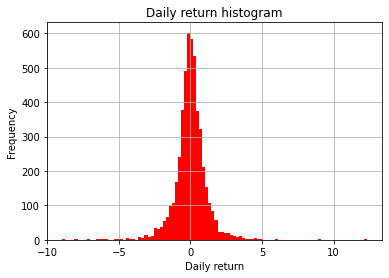

In [227]:
# Plot the histogram
data['daily_return'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

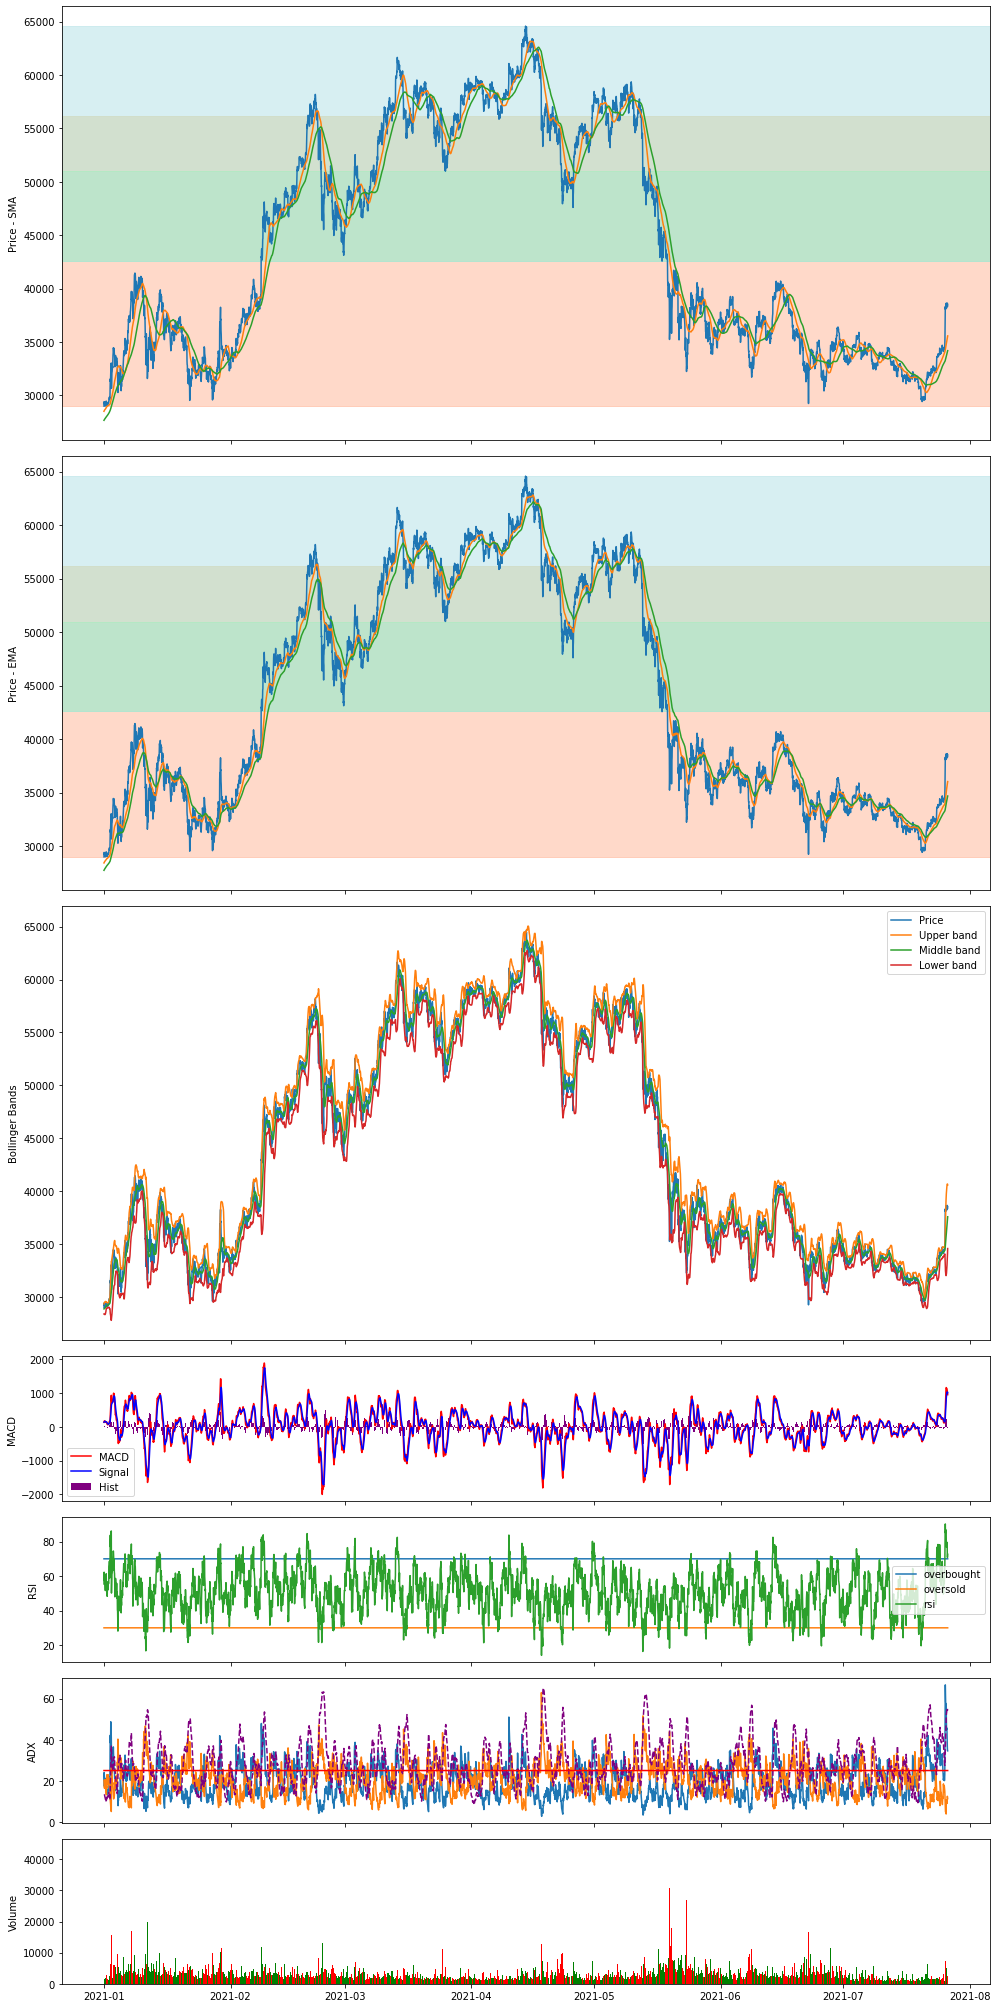

In [228]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.legend()
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.bar(data.index, data['MACDHist'], label='Hist', color="purple", width = timedelta(hours=1))
ax4.plot(data.index, data['MACDSignal'], label='Signal', color='blue')
ax4.legend()
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['rsi'], label='rsi')
ax5.legend()
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
# make bar plots and color differently depending on up/down for the day
pos = data['OpenPrice'] - data['ClosePrice'] < 0
neg = data['OpenPrice'] - data['ClosePrice'] > 0
ax7.bar(data.index[pos], data[pos]['Volume'], color='green', width = timedelta(hours=1))
ax7.bar(data.index[neg], data[neg]['Volume'], color='red', width = timedelta(hours=1))

#ax7.bar(data.index, data['Volume'] / 1000000, width = timedelta(hours=4))
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [229]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

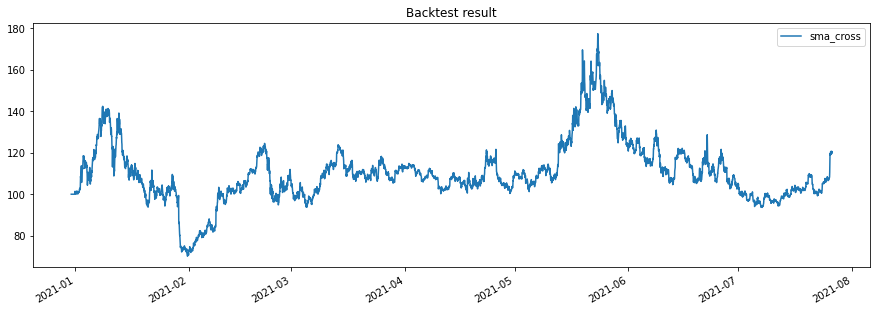

In [230]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_sma_cross = signal_strategy(price_data.copy(), signal, 'sma_cross')

bt_result = bt.run(bt_sma_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

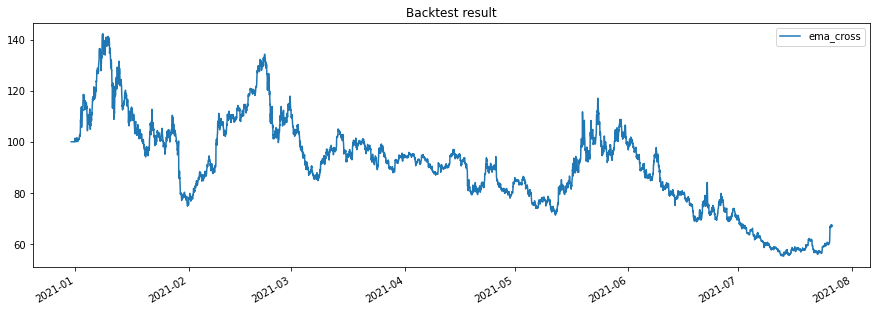

In [231]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_ema_cross = signal_strategy(price_data.copy(), signal, 'ema_cross')

bt_result = bt.run(bt_ema_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

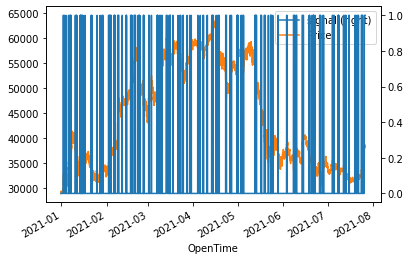

In [232]:
from backtest_utils import get_rsi_signal, signal_strategy

signal = get_rsi_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

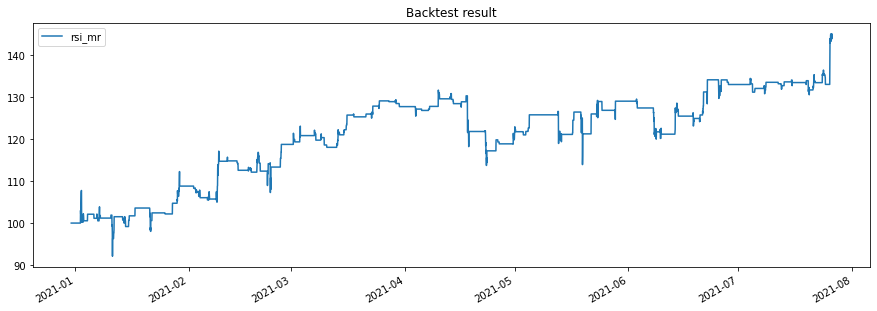

In [233]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

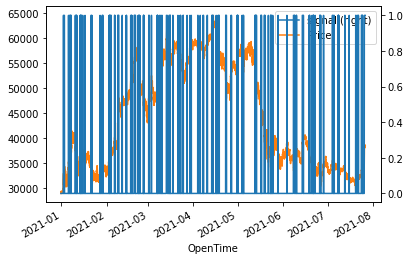

In [234]:
from backtest_utils import get_rsi_adx_signal, signal_strategy

signal = get_rsi_adx_signal(data[['rsi']].copy(), data[['ADX']])

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

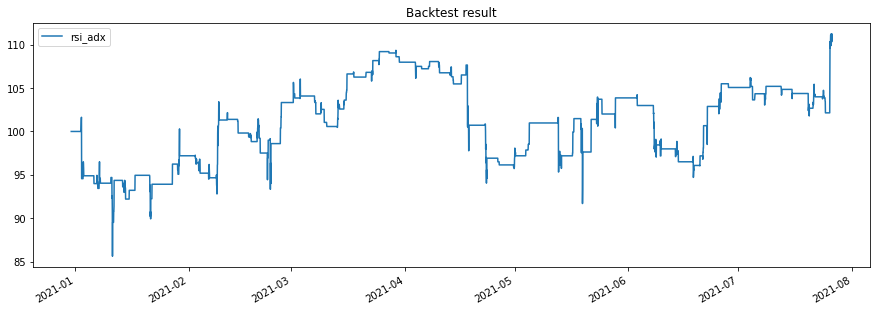

In [235]:
bt_rsi_adx = signal_strategy(price_data.copy(), signal, 'rsi_adx')

bt_result = bt.run(bt_rsi_adx)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

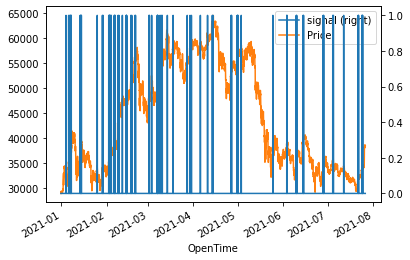

In [236]:
from backtest_utils import get_rsi_plus_signal, signal_strategy

signal = get_rsi_plus_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

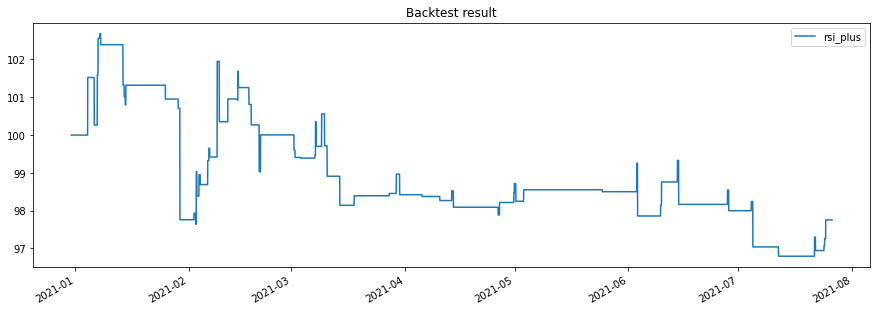

In [237]:
bt_rsi_plus = signal_strategy(price_data.copy(), signal, 'rsi_plus')

bt_result = bt.run(bt_rsi_plus)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

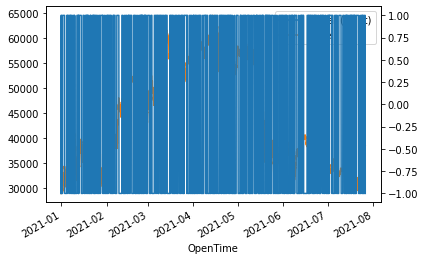

In [238]:
from backtest_utils import get_macd_signal, signal_strategy

signal = get_macd_signal(data[['MACDSignal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

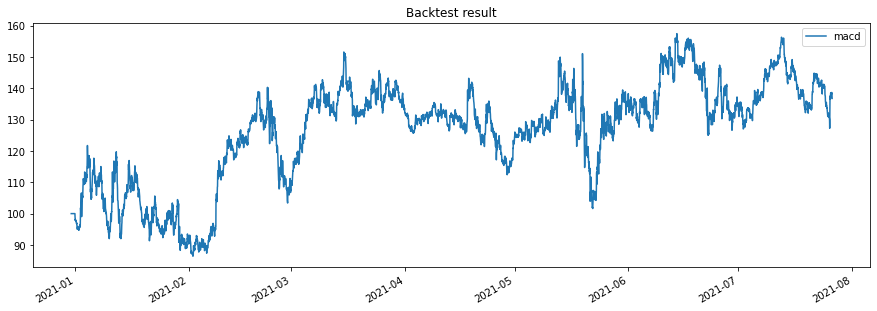

In [239]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

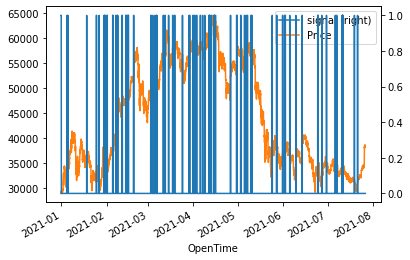

In [240]:
from backtest_utils import get_sma_macd_signal, signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

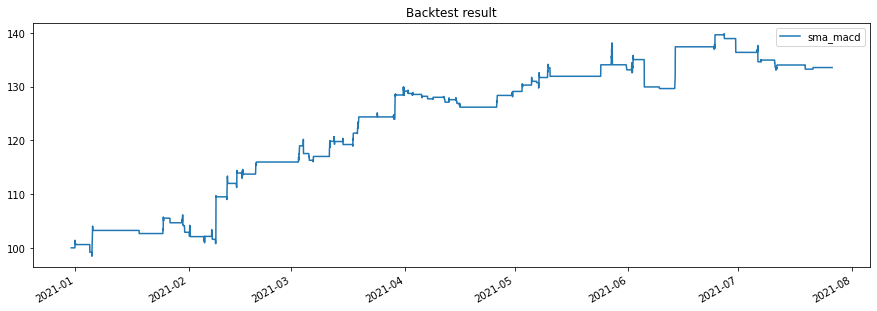

In [241]:
bt_sma_macd = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_sma_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [242]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma10 = signal_above_strategy(price_data.copy(), data[['SMA10']].copy(), name='SMA10')
bt_sma20 = signal_above_strategy(price_data.copy(), data[['SMA20']].copy(), name='SMA20')
bt_sma30 = signal_above_strategy(price_data.copy(), data[['SMA30']].copy(), name='SMA30')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

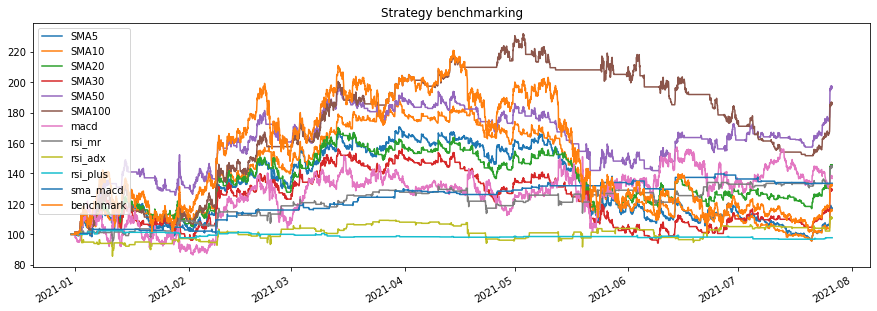

In [243]:
# Run all backtests and plot the resutls
bt_results = bt.run(bt_sma5,bt_sma10, bt_sma20, bt_sma30, bt_sma50, bt_sma100, bt_macd, bt_rsi, bt_rsi_adx, bt_rsi_plus, bt_sma_macd, bt_benchmark)
#bt_results = bt.run(bt_rsi, bt_sma50, bt_benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [244]:
bt_results.display()

Stat                 SMA5        SMA10       SMA20       SMA30       SMA50       SMA100      macd        rsi_mr      rsi_adx     rsi_plus    sma_macd    benchmark
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31
End                  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26  2021-07-26
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         16.77%      15.47%      45.39%      29.47%      96.98%      86.32%      36.76%      44.64%      10.96%      -2.24%      33.56%      32.41%
Daily Sharpe         0.6

In [245]:
# Obtain all backtest stats
resInfo = bt_results.stats
print(resInfo.loc['total_return'].sort_values(ascending=False))

best_strategy = ''
best_total_return = -1
for strategy, total_return in zip(resInfo.loc['total_return'].index, resInfo.loc['total_return'].values):
    if total_return > best_total_return:
        best_total_return = total_return
        best_strategy = strategy

bt_best = bt_results.backtests[best_strategy]
print('Best Strategy: ' + best_strategy)

SMA50        0.969828
SMA100       0.863235
SMA20        0.453932
rsi_mr       0.446436
macd         0.367639
sma_macd     0.335638
benchmark    0.324124
SMA30        0.294678
SMA5         0.167697
SMA10        0.154687
rsi_adx      0.109588
rsi_plus    -0.022442
Name: total_return, dtype: object
Best Strategy: SMA50


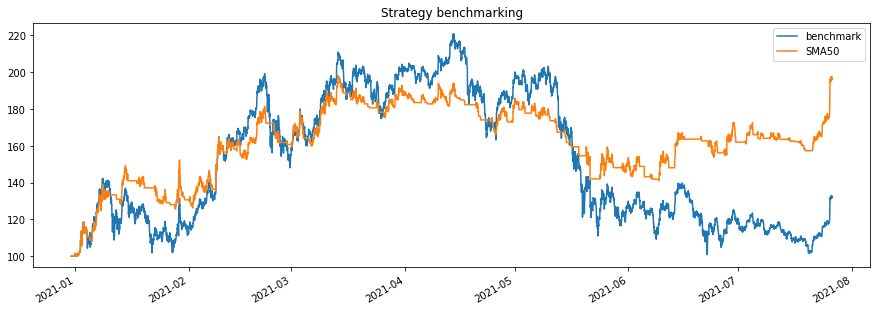

In [250]:
bt_results_best = bt.run(bt_benchmark, bt_best)
bt_results_best.plot(title='Strategy benchmarking')
plt.show()

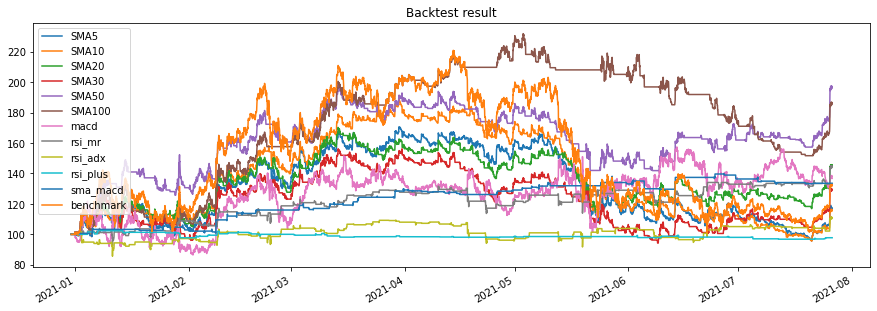

          SMA5    SMA10   SMA20   SMA30    SMA50   SMA100    macd  rsi_mr  \
mtd      1.52%    2.48%  12.61%  17.56%   21.59%    6.64%   1.06%   8.78%   
3m     -25.08%  -31.40%   0.40%   1.14%   11.68%  -14.58%  13.49%  21.70%   
6m      11.57%    3.56%  26.76%  21.55%   53.78%   73.64%  36.65%  41.57%   
ytd     16.77%   15.47%  45.39%  29.47%   96.98%   86.32%  36.76%  44.64%   
1y        nan%     nan%    nan%    nan%     nan%     nan%    nan%    nan%   
3y        nan%     nan%    nan%    nan%     nan%     nan%    nan%    nan%   
5y        nan%     nan%    nan%    nan%     nan%     nan%    nan%    nan%   
10y       nan%     nan%    nan%    nan%     nan%     nan%    nan%    nan%   
incep   31.46%   28.89%  93.56%  57.73%  230.76%  199.84%  73.75%  91.80%   

      rsi_adx rsi_plus sma_macd benchmark  
mtd     5.60%   -0.25%   -2.07%     9.82%  
3m     15.41%   -0.47%    4.04%   -28.43%  
6m     18.15%   -3.17%   27.61%    18.43%  
ytd    10.96%   -2.24%   33.56%    32.41%  
1y       

In [247]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)

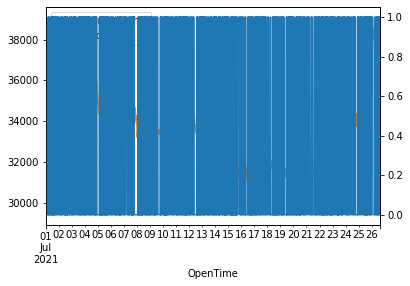

In [248]:
from backtest_utils import get_5_minute_signal, signal_strategy
import bt

data_5m = df_5m.copy()
data_5m['MACD'], data_5m['MACDSignal'], data_5m['MACDHist'] = macd(data_5m.ClosePrice)
data_5m['EMA20'] = ema(data_5m['ClosePrice'], 20)
data_5m = data_5m['2021-7-1':]

signal = get_5_minute_signal(data_5m[['ClosePrice']].copy(), data_5m[['MACDHist']].copy(), data_5m[['EMA20']].copy())

# Merge the data
combined_df = bt.merge(signal, data_5m[['ClosePrice']])
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

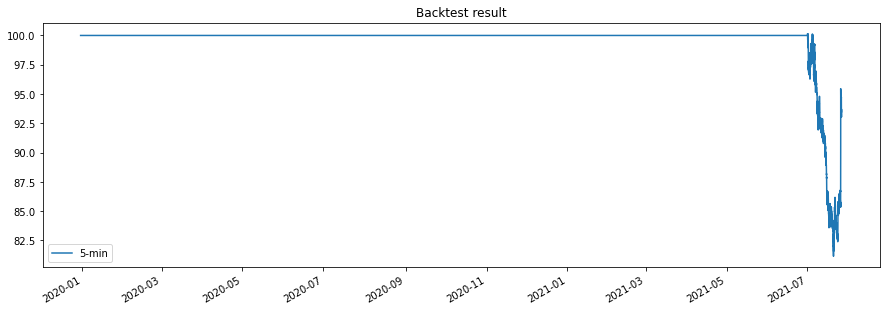

In [249]:
bt_backtest = signal_strategy(df_5m[['ClosePrice']].copy(), signal, '5-min')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()